In [1]:
"""Contains evaluation of image semgemntation results & model export functionalities.
"""

'Contains evaluation of image semgemntation results & model export functionalities.\n'

In [2]:
import pathlib
import torch
import config
from typing import List, Union, Tuple
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, jaccard_score
import itertools
import u_net
import dataset as dataset
from torchvision import transforms
from skimage import transform as trans
import numpy as np

In [3]:
def plot_loss(
    model_name: str, train_loss: List[float], valid_loss: List[float]
) -> None:
    """Visualizes the loss data of the trained model.

    Args:
        model_name: Name of the trained model.
        train_loss: Loss data generated during training.
        valid_loss: Loss data generated during validation.
    """
    plt.figure(figsize=(12, 7))
    plt.suptitle(model_name + " loss values")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()

In [4]:
def txt_to_list(input_path: Union[pathlib.Path, str]) -> List[str]:
    """Loads a .txt file into a list.
    Args:
        input_path: Input path to the txt file.

    Returns:
        List containing data from the .txt file.
    """
    with open(input_path, "r") as f:
        data = f.read().splitlines()
    
    return data

In [5]:
def compute_iou(arr1: np.ndarray, arr2: np.ndarray):
    """Performs basic IoU calculation.
    """
    intersection = np.logical_and(arr1, arr2)
    union = np.logical_or(arr1, arr2)
    
    return np.sum(intersection) / np.sum(union)

In [6]:
def print_image_data(img: np.ndarray):
    """Prints basic data about an image array.
    """
    print('Shape of input image: ', img.shape)
    print('Data type: ', img.dtype)
    print('Max element: ', img.max())
    print('Min element: ', img.min())
    print('Total number of elements: ', img.size)
    print('Number of unique elements: ', np.unique(img).size)
    print('Average value: ', np.average(img))

In [7]:
def plot_confusion_matrix(cm: np.ndarray, classes: List[str], normalize: bool = False,
                          title: str = 'Confusion matrix',
                          cmap: matplotlib.colors.LinearSegmentedColormap = plt.cm.Blues):
    """Visualizes confusion matrix.
    Source: https://deeplizard.com/learn/video/0LhiS6yu2qQ

    Args:
        cm: Confussion matrix.
        classes: List of classes.
        normalize: If true, confusion matrix will be normalized.
        title: Title of the plotted matrix.
        cmap: Used color map.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def process_conf_mat(confusion_matrix: np.ndarray):
    """Processeses confusion matrix to extrapolate relevant statistical metrics.
    If one of the metrics is impossible to compute (for example, precision for a non existing class),
    the function will return 0 for that metric.

    Ref: https://stackoverflow.com/a/43331484

    Args:
        confusion_matrix: Input confusion_matrix.
    """
    fp = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix) # False positives.
    fn = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix) # False negatives.
    tp = np.diag(confusion_matrix) # True positives.
    tn = confusion_matrix.sum() - (fp + fn + tp) # True negatives.
    
    if np.all(tp+fp):
        precision = tp/(tp+fp)
        precision = precision[precision!=0]
    else:
        precision = 0

    if np.all(tp+fp+fn+tn):
        accuracy = (tp+tn)/(tp+fp+fn+tn)
        accuracy = accuracy[accuracy!=0]
    else:
        accuracy = 0

    if np.all(tp+fn):
        sensitivity = tp/(tp+fn) # = Recall, or true positive rate.
        sensitivity = sensitivity[sensitivity!=0]
    else:
        sensitivity = 0

    if np.all(tn+fp):
        specificity = tn/(tn+fp) # = Fallout, or true negative rate.
        specificity = specificity[specificity!=0]
    else:
        specificity = 0

    if np.all(2*tp + fp + fn):
        dice_score = 2*tp / (2*tp + fp + fn)
        dice_score = dice_score[dice_score!=0]
    else:
        dice_score = 0

    return {'precision': float(np.average(precision)), 'accuracy': float(np.average(accuracy)),
            'sensitivity': float(np.average(sensitivity)), 'specificity': float(np.average(specificity)),
            'dice_score': float(np.average(dice_score))}

In [9]:
def one_hot_to_multiclass(gt: np.ndarray, inf: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Turns the one-hot-encoded output into a single frame multiclass output, flattend in the end.
    Function assumes non-overlapping predictions - each pixel can only have one class label.
    Every pixel that contains the element of the class is labeled with the class index,
    starting at 0 until n_classes. 
    Class predictions will overlap the previous predictions. This is why it is crucial to have the most
    important class last.

    Args:
        gt: Input ground truth one-hot-encoded arrray.
        inf: Input inference one-hot-encoded arrray.

    Returns:
        Tuple of flattened class labels.
    """
    # Ensure that the least important class is first and most important class last.
    gt = gt[:,:,[1,2,0]]
    inf = inf[:,:,[1,2,0]]
    
    gt_multiclass = np.zeros((gt.shape[0], gt.shape[1]))
    inference_multiclass = np.zeros((inf.shape[0], inf.shape[1]))
    
    for class_idx in range(gt.shape[2]):
        gt_multiclass[gt[:, :, class_idx] != 0] = class_idx
        inference_multiclass[inf[:, :, class_idx] != 0] = class_idx
    
    gt_multiclass = gt_multiclass.flatten()
    inference_multiclass = inference_multiclass.flatten()

    return gt_multiclass, inference_multiclass

In [10]:
model_name = 'test'

# Plot the loss

In [11]:
TRAINED_MODEL_PATH = f'/home/vice-calibras/mus_brain_seg/trained_models/{model_name}.pt'
TRAIN_LOSS_PATH = f'/home/vice-calibras/mus_brain_seg/trained_models/{model_name}_training_loss.txt'
VALID_LOSS_PATH = f'/home/vice-calibras/mus_brain_seg/trained_models/{model_name}_validation_loss.txt'

In [12]:
model_name = pathlib.Path(TRAINED_MODEL_PATH).stem
train_loss= txt_to_list(TRAIN_LOSS_PATH)
valid_loss= txt_to_list(VALID_LOSS_PATH)

In [13]:
# Convert str to float & tidy up.
train_loss = [float(el) for el in train_loss]
train_loss = [round(el, 4) for el in train_loss]

valid_loss = [float(el) for el in valid_loss]
valid_loss = [round(el, 4) for el in valid_loss]

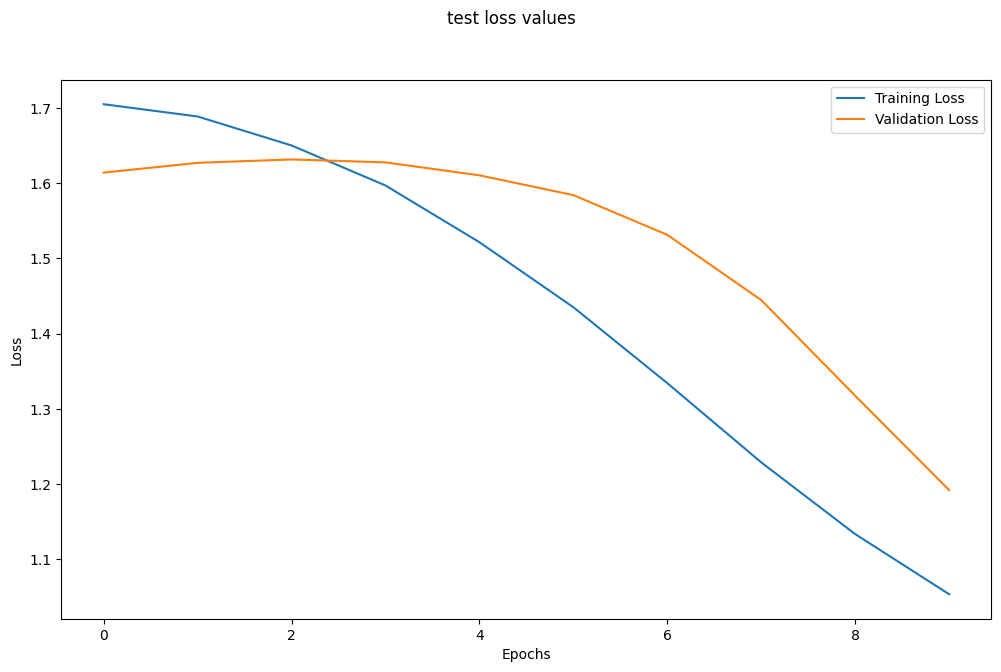

In [14]:
plot_loss(model_name, train_loss, valid_loss)

# Load the model & dataset

In [15]:
TRAINED_STATE_DICT_PATH = f'/home/vice-calibras/mus_brain_seg/trained_models/{model_name}_state_dict'

In [16]:
# Load global config.
config_file = config.Config()

In [17]:
# Set the device & clean the memory.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
torch.cuda.empty_cache()

Device:  cpu


In [18]:
# Load the test dataset & with applied transformations.
test_dir = pathlib.Path(config_file.config["dataset"]["test"]["image"])
mask_dir = pathlib.Path(config_file.config["dataset"]["test"]["mask"])
# Get a list of names of the contents of the folder.
all_images = list(path.name for path in pathlib.Path.iterdir(test_dir))

test_transforms = transforms.Compose([dataset.OneHotEncodeMask(dataset.COLOR_DICT), 
                                     dataset.Resize(config_file.config["output_size"]), dataset.ToTensor()])

test_set = dataset.SegMaskDataset(test_dir, mask_dir, all_images,all_images, train = True,
                                transforms = test_transforms, store_original_size = True,
                                store_original_name = True)

batch_size = config_file.config["batch_size"]

print("Loading testing dataset!")
test_loader=DataLoader(test_set,batch_size=batch_size,shuffle=False, num_workers=4)

# Instantiate a model. Ensure that the same parameters are used as during with training!
model=u_net.UNet(3,3, True)
optimizer=optim.SGD(model.parameters(),momentum=0.99,lr=config_file.config["lr"]) 
#loss_f=nn.CrossEntropyLoss(reduction='mean')
class_weights = torch.tensor([1.5, 1.0, 1.0], dtype=torch.float).to(device)
loss_f=nn.CrossEntropyLoss(weight=class_weights , reduction='mean')
# loss_f=nn.BCEWithLogitsLoss(reduction='mean')

model.to(device)

Loading testing dataset!


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [19]:
# Load the trained model.
# GPU.
#model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH))

# CPU.
model.load_state_dict(torch.load(TRAINED_STATE_DICT_PATH, map_location=torch.device('cpu')))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

# Visualize single sample & inference 

In [28]:
n_sample = 3 # In the batch.
sample = next(iter(test_loader))
sample['image'][n_sample].shape

torch.Size([3, 128, 128])

In [29]:
def one_hot_to_rgb(one_hot_mask, color_dict):
    """Convert one-hot encoded mask back to RGB colors for visualization."""
    color_values = list(color_dict.values())
    one_hot_hw = one_hot_mask.transpose(1, 2, 0)
    rgb_mask = np.zeros((one_hot_hw.shape[0], one_hot_hw.shape[1], 3), dtype=np.uint8)
    
    # For each pixel, find the class with the maximum probability
    class_predictions = np.argmax(one_hot_hw, axis=2)
    
    # Apply colors to all pixels (no threshold - even pure zeros will be background)
    for class_idx, color in enumerate(color_values):
        class_mask = class_predictions == class_idx
        rgb_mask[class_mask] = color
    
    return rgb_mask

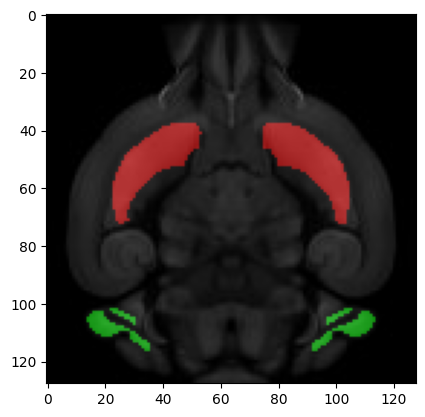

In [36]:
# Display sample image with the ground truth mask.
img = sample['image'][n_sample].numpy().transpose(1,2,0)
msk_one_hot = sample['mask'][n_sample].numpy()  # Keep as (C, H, W)
msk_rgb = one_hot_to_rgb(msk_one_hot, dataset.COLOR_DICT)  # Convert to RGB

plt.imshow(img)
plt.imshow(msk_rgb, alpha=0.5)  # Now showing proper RGB colors

In [31]:
sample['original_name'][n_sample]

'coronal_194_0025'

In [32]:
# Perform inference on a single image.
with torch.no_grad():  # Turn off the gradients for validation.
    sample = next(iter(test_loader))
    image=sample['image'].to(device).float()
    mask=sample['mask'].to(device).float()
    
    output = model(image)

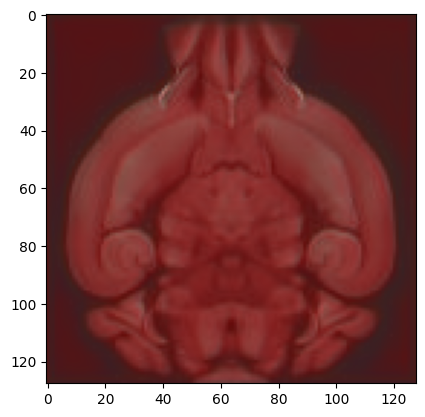

In [38]:
# Show inference results.
img = sample['image'][n_sample].numpy().transpose(1,2,0)
msk_one_hot = sample['mask'][n_sample].numpy()  # Keep as (C, H, W)
msk_rgb = one_hot_to_rgb(msk_one_hot, dataset.COLOR_DICT)  # Convert to RGB
inference=output[n_sample].cpu().numpy().transpose(1,2,0)
plt.imshow(img)
plt.imshow(inference,alpha=0.5) 

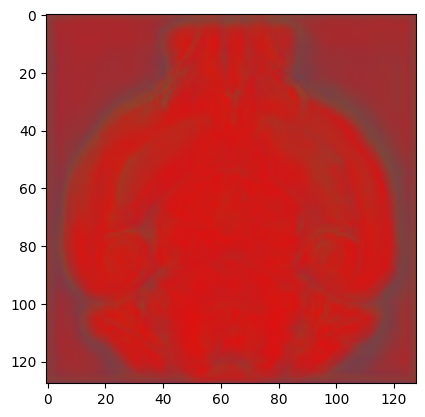

In [39]:
plt.imshow(inference) 

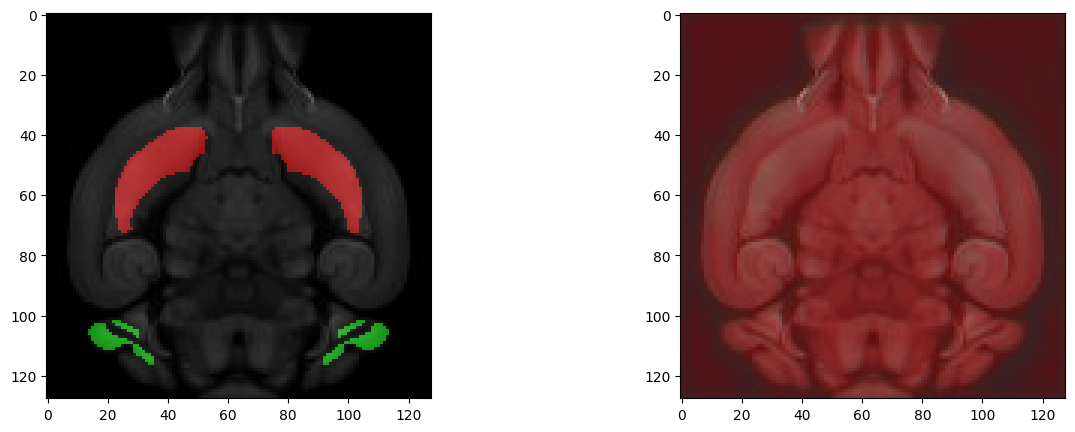

In [40]:
# Show the ground truth next to inference.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(img)
ax1.imshow(msk_rgb, alpha = 0.5)
ax2.imshow(img)
ax2.imshow(inference, alpha = 0.5)

Text(0.5, 1.0, '2')

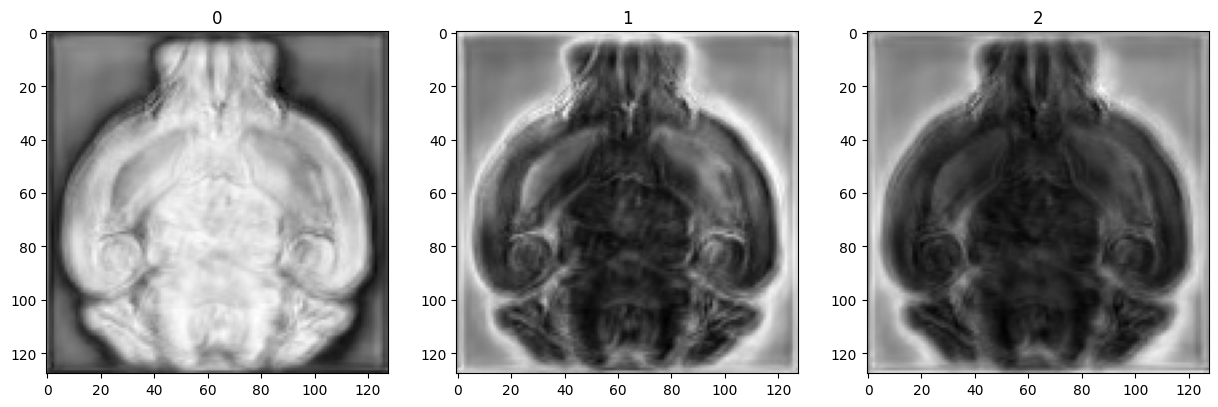

In [41]:
# Display all 3 channels of the inference.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(inference[:, :, 0], cmap='gray')
ax1.set_title('0')

ax2.imshow(inference[:, :, 1], cmap='gray')
ax2.set_title('1')

ax3.imshow(inference[:, :, 2], cmap='gray')
ax3.set_title('2')

# Compute basic metrics

In [42]:
# Round the gt and inference data, to remove numerical error from the IoU computation.
msk_rgb = np.round(msk, 2)
inference = np.round(inference, 2)

In [43]:
print_image_data(msk_rgb)

Shape of input image:  (128, 128, 3)
Data type:  float64
Max element:  1.0
Min element:  0.0
Total number of elements:  49152
Number of unique elements:  2
Average value:  0.32244873046875


In [44]:
print_image_data(inference)

Shape of input image:  (128, 128, 3)
Data type:  float32
Max element:  0.87
Min element:  0.06
Total number of elements:  49152
Number of unique elements:  69
Average value:  0.33334228


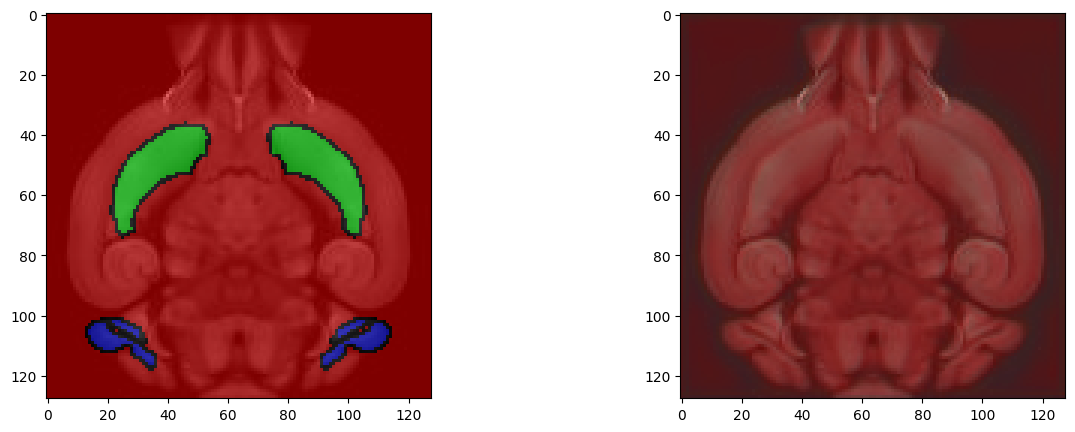

In [47]:
# Test the rounded output.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(img)
ax1.imshow(msk_rgb, alpha = 0.5)
ax2.imshow(img)
ax2.imshow(inference, alpha = 0.5)

In [46]:
print(compute_iou(msk, inference))

0.32244873046875


In [34]:
# Plot one confussion matrix of the pixel accuracy.
# Get a multiclass output.
gt_multiclass, inference_multiclass = one_hot_to_multiclass(msk, inference)

In [35]:
cm = confusion_matrix(gt_multiclass, inference_multiclass)

Normalized confusion matrix


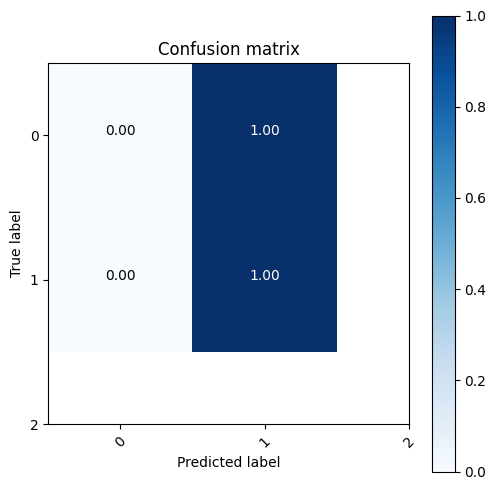

In [36]:
plt.figure(figsize=(5,5))
plot_confusion_matrix(cm, ['0', '1', '2'], normalize=True)

In [37]:
# Extrapolate relevant statistical metrics.
metrics = process_conf_mat(cm)

/home/vice-calibras/mus_brain_seg/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/vice-calibras/mus_brain_seg/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [38]:
metrics

{'precision': 0.0,
 'accuracy': 0.5,
 'sensitivity': 0.0,
 'specificity': 1.0,
 'dice_score': nan}

In [39]:
# Compute F1 score.
f1 = f1_score(gt_multiclass, inference_multiclass, average='micro')
f1

0.0

In [40]:
# Compute IoU (according to scikit-learn).
iou = jaccard_score(gt_multiclass, inference_multiclass, average='micro')
iou

0.0

In [41]:
# Resize the image, gt & inference to original size.
img_resized = trans.resize(img,(sample['original_height'][n_sample], sample['original_width'][n_sample]))
msk_resized = trans.resize(msk,(sample['original_height'][n_sample], sample['original_width'][n_sample]))
inference_resized = trans.resize(inference,(sample['original_height'][n_sample], sample['original_width'][n_sample]))

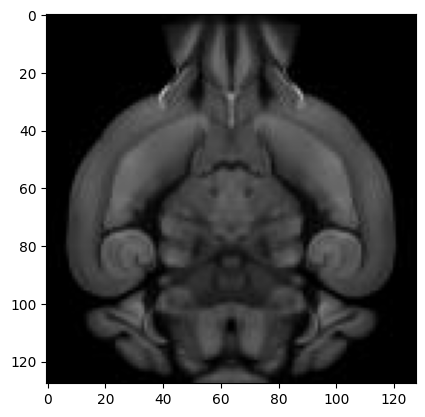

In [42]:
plt.imshow(img_resized) 

In [43]:
print_image_data(inference_resized)

Shape of input image:  (128, 128, 3)
Data type:  float32
Max element:  0.84
Min element:  0.05
Total number of elements:  49152
Number of unique elements:  59
Average value:  0.33332846


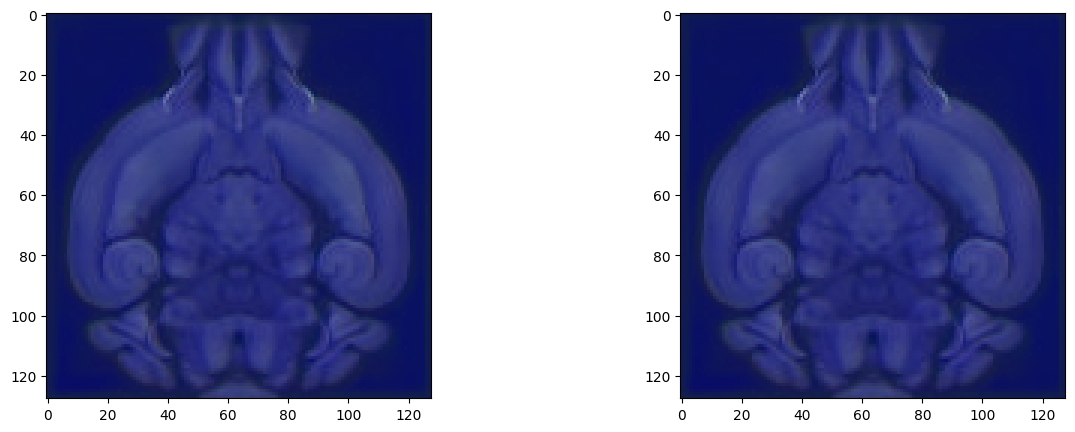

In [44]:
# Show the inference next to original sized inference.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(img)
ax1.imshow(inference, alpha = 0.5)
ax2.imshow(img_resized)
ax2.imshow(inference_resized, alpha = 0.5)

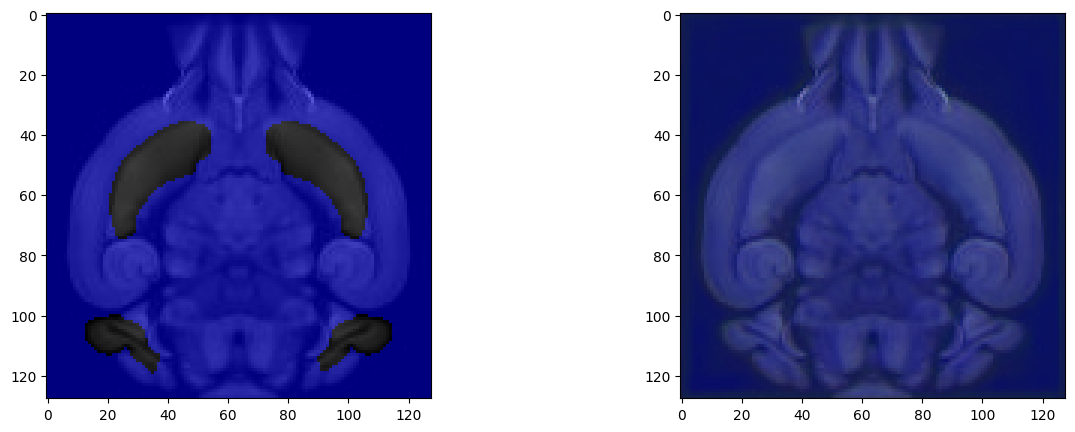

In [45]:
# Show the ground truth next to inference.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(img_resized)
ax1.imshow(msk_resized, alpha = 0.5)
ax2.imshow(img_resized)
ax2.imshow(inference_resized, alpha = 0.5)

# Evaluate whole dataset

In [46]:
# Perform inference on the whole test dataset.
gt = []
outputs = []
original_heights = []
original_widths = []
original_names = []
with torch.no_grad():
    for sample in test_loader:
        image=sample['image'].to(device).float()
        mask=sample['mask'].to(device).float()

        gt.append(mask)
        output = model(image)
        outputs.append(output)
        original_heights.append(sample['original_height'])
        original_widths.append(sample['original_width'])
        original_names.append(sample['original_name'])

In [47]:
# Load the ground truth masks without resizing - raw ground truths.
# Because the default pytorch DataLoader needs to have constant tensor shapes, and input data set has variable sizes,
# it is not possible to create a DataLoader object - no batches.
raw_gt_transforms = transforms.Compose([dataset.OneHotEncodeMask(dataset.COLOR_DICT), dataset.ToTensor()])
raw_gt_set = dataset.SegMaskDataset(test_dir, mask_dir, all_images,all_images, train = True,
                                transforms = raw_gt_transforms, store_original_name = True)

In [48]:
# Isolate one raw ground truth & inference pair. Match according to the 'original_name' field.
batch = 0
n_sample = 7
target_gt_idx = 0 # With matching 'original name'.

for raw_gt_idx, raw_gt in enumerate(raw_gt_set):
    if original_names[batch][n_sample] == raw_gt['original_name']:
        target_gt_idx = raw_gt_idx

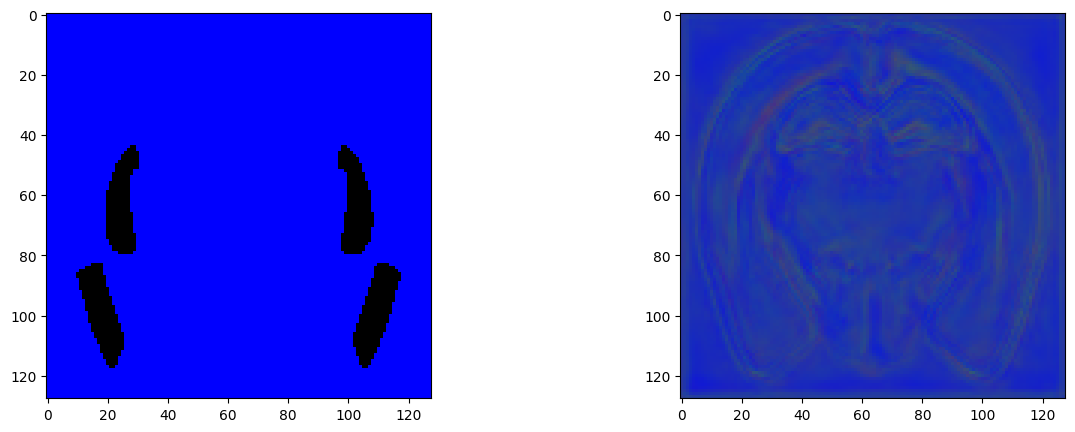

In [49]:
# Show the inference next to raw ground truth.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(raw_gt_set[target_gt_idx]['mask'].cpu().numpy().transpose(1,2,0))
ax2.imshow(outputs[batch][n_sample].cpu().numpy().transpose(1,2,0))

In [50]:
# Compute the metrics for the whole test dataset - resized ground truths.
test_metrics = []
for batch_idx, batch in enumerate(outputs):
    for sample_idx, _ in enumerate(batch):
        gt_msk = np.round(gt[batch_idx][sample_idx].cpu().numpy().transpose(1,2,0), 2)
        inf_msk = np.round(outputs[batch_idx][sample_idx].cpu().numpy().transpose(1,2,0), 2)

        # Resize to original, to compute production IoU.
        gt_msk = trans.resize(gt_msk,(original_heights[batch_idx][sample_idx], original_widths[batch_idx][sample_idx]))
        inf_msk = trans.resize(inf_msk,(original_heights[batch_idx][sample_idx], original_widths[batch_idx][sample_idx]))

        # Get a multiclass output & compute confussion matrix.
        gt_multiclass, inference_multiclass = one_hot_to_multiclass(gt_msk, inf_msk)
        cm = confusion_matrix(gt_multiclass, inference_multiclass)
        # Extrapolate basic statistical metrics.
        metrics = process_conf_mat(cm)
        # Compute F1 score.
        f1 = f1_score(gt_multiclass, inference_multiclass, average='micro')
        # Compute IoU.
        iou = compute_iou(gt_msk, inf_msk)

        metrics['f1'] = f1
        metrics['iou'] = iou
        test_metrics.append(metrics)

/home/vice-calibras/mus_brain_seg/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/vice-calibras/mus_brain_seg/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/vice-calibras/mus_brain_seg/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/vice-calibras/mus_brain_seg/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/vice-calibras/mus_brain_seg/.venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/vice-calibras/mus_brain_seg/.venv/lib/python3.10/site-packages/num

In [51]:
# Compute the average metrics for the whole test dataset.
precisions = []
accuracies = []
sensitivities = []
specificities = []
dice_scores = []
f1s = []
ious = []
for metric in test_metrics:
    precisions.append(metric['precision'])
    accuracies.append(metric['accuracy'])
    sensitivities.append(metric['sensitivity'])
    specificities.append(metric['specificity'])
    dice_scores.append(metric['dice_score'])
    f1s.append(metric['f1'])
    ious.append(metric['iou'])

print('Average precision: ', round(sum(precisions)/len([prec for prec in precisions if prec != 0]), 2))
print('Average accuracy: ', round(sum(accuracies)/len([acc for acc in accuracies if acc != 0]), 2))
print('Average sensitivity (recall): ', round(sum(sensitivities)/len([sens for sens in sensitivities if sens != 0]), 2))
print('Average specificity (fallout): ', round(sum(specificities)/len([spec for spec in specificities if spec != 0]), 2))
print('Average dice_score: ', round(sum(dice_scores)/len([ds for ds in dice_scores if ds != 0]), 2))
print('Average f1: ', round(sum(f1s)/len([f1 for f1 in f1s if f1 != 0]), 2))
print('Average iou: ', round(sum(ious)/len([iou for iou in ious if iou != 0]), 2))

ZeroDivisionError: float division by zero

In [ ]:
# Compute the metrics for the whole test dataset - raw ground truths.
test_metrics = []
for batch_idx, batch in enumerate(outputs):
    for sample_idx, _ in enumerate(batch):
        inf_msk = np.round(outputs[batch_idx][sample_idx].cpu().numpy().transpose(1,2,0), 2)

        # Resize to original, to compute production IoU.
        inf_msk = trans.resize(inf_msk,(original_heights[batch_idx][sample_idx], original_widths[batch_idx][sample_idx]))       

        for raw_gt in raw_gt_set:
            if original_names[batch_idx][sample_idx] == raw_gt['original_name']:
                gt_msk = np.round(raw_gt['mask'].numpy().transpose(1,2,0), 2) 
        
        # Get a multiclass output & compute confussion matrix.
        gt_multiclass, inference_multiclass = one_hot_to_multiclass(gt_msk, inf_msk)
        cm = confusion_matrix(gt_multiclass, inference_multiclass)
        # Extrapolate basic statistical metrics.
        metrics = process_conf_mat(cm)
        # Compute F1 score.
        f1 = f1_score(gt_multiclass, inference_multiclass, average='micro')
        # Compute IoU.
        iou = compute_iou(gt_msk, inf_msk)

        metrics['f1'] = f1
        metrics['iou'] = iou
        test_metrics.append(metrics)

In [ ]:
# Compute the average metrics for the whole test dataset.
precisions = []
accuracies = []
sensitivities = []
specificities = []
dice_scores = []
f1s = []
ious = []
for metric in test_metrics:
    precisions.append(metric['precision'])
    accuracies.append(metric['accuracy'])
    sensitivities.append(metric['sensitivity'])
    specificities.append(metric['specificity'])
    dice_scores.append(metric['dice_score'])
    f1s.append(metric['f1'])
    ious.append(metric['iou'])

print('Average precision: ', round(sum(precisions)/len([prec for prec in precisions if prec != 0]), 2))
print('Average accuracy: ', round(sum(accuracies)/len([acc for acc in accuracies if acc != 0]), 2))
print('Average sensitivity (recall): ', round(sum(sensitivities)/len([sens for sens in sensitivities if sens != 0]), 2))
print('Average specificity (fallout): ', round(sum(specificities)/len([spec for spec in specificities if spec != 0]), 2))
print('Average dice_score: ', round(sum(dice_scores)/len([ds for ds in dice_scores if ds != 0]), 2))
print('Average f1: ', round(sum(f1s)/len([f1 for f1 in f1s if f1 != 0]), 2))
print('Average iou: ', round(sum(ious)/len([iou for iou in ious if iou != 0]), 2))